## 👪  [Day 20](https://adventofcode.com/2018/day/20)

In [0]:
class Room:
  """A Room in the map"""
  
  def __init__(self):
    """Position and Neighbors of the room"""
    self.north = None
    self.east = None
    self.south = None
    self.west = None
    self.dist = 0
    self.x = 0
    self.y = 0        
  
  def merge(self, other):
    """Merge the `other` room in the current one"""
    assert self.x == other.x and self.y == other.y
    self.dist = min(self.dist, other.dist)
    self.north = self.north or other.north
    self.east = self.east or other.east
    self.south = self.south or other.south
    self.west = self.west or other.west    
    
  def add_room(self, c):
    """Add a new room by making step in direction `c` from the current room"""
    cases = {'E': ('east', 'west'), 'N': ('north', 'south'), 'W': ('west', 'east'), 'S': ('south', 'north')}
    nxt = getattr(self, cases[c][0])
    if nxt is None:
      new_room = Room()
      setattr(new_room, cases[c][1], self)
      new_room.dist = self.dist + 1
      setattr(self, cases[c][0], new_room)
      if c == 'S':
        new_room.x = self.x + 1
        new_room.y = self.y
      elif c == 'N':
        new_room.x = self.x - 1
        new_room.y = self.y
      elif c == 'W':
        new_room.x = self.x
        new_room.y = self.y - 1
      elif c == 'E':
        new_room.x = self.x
        new_room.y = self.y + 1
      return new_room
    else:
      nxt.dist = min(nxt.dist, self.dist + 1)
      return nxt    
    
  def add_rooms_from_path(self, path, visited):
    """Browse `path` from the current room and add visited rooms to the accumulator"""
    if len(path):
      nxt = self.add_room(path[0])
      # Add to acucmulator
      if (nxt.x, nxt.y) in visited:
        visited[nxt.x, nxt.y].merge(nxt)
      else:
        visited[(nxt.x, nxt.y)] = nxt
      # Continue browsing
      return nxt.add_rooms_from_path(path[1:], visited)
    else:
      return self

In [0]:
def browse_path(path, origins, visited):
  """Given a path containing N, E, W, S directions (no parenthesis or pipe), 
    and a list of possible origin points returns """
  if len(path.strip()):
    next_origins = [0] * len(origins)
    for i, origin in enumerate(next_origins):
      next_origins[i] = origins[i].add_rooms_from_path(path, visited)
    return next_origins
  else:
    return origins
  
  
def clean_rooms(rooms):
  """Remove duplicates by merging rooms with same (x, y) position"""
  filtered_rooms = []
  for r1 in rooms:
    duplicate = False
    # Find duplicate and merge
    for r2 in filtered_rooms:
      if r1 == r2:
        r2.merge(r1)
        duplicate = True
        break
    # if not, add the room
    if not duplicate:
      filtered_rooms.append(r1)
  return filtered_rooms


def display(visited):  
  """Display map using matplotlib"""
  from matplotlib import pyplot as plt
  rooms = list(visited.values())
  xs = [r.x for r in rooms]
  ys = [r.y for r in rooms]
  xmin = min(xs); xmax = max(xs); ymin = min(ys); ymax = max(ys)
  wall_value = -10
  #factory = np.zeros((2 * (xmax + 1 - xmin), 2 * (ymax + 1 - ymin))) + wall_value
  factory = [[wall_value for _ in range(2 * (ymax + 1 - ymin))] for _ in range(2 * (xmax + 1 - xmin))]
  for r in rooms:
    x = 2 * (r.x - xmin)
    y = 2 * (r.y - ymin)
    factory[x][y] =  r.dist 
    factory[x][y + 1] = wall_value if r.east is None else r.dist
    factory[x][y - 1] = wall_value if r.west is None else r.dist
    factory[x + 1][y] = wall_value if r.south is None is None else r.dist
    factory[x - 1][y] = wall_value if r.north is None else r.dist
  # Display map
  plt.figure(figsize=(14, 12))
  plt.title('Factory map and distance heatmaps', fontsize=18)
  plt.pcolor(factory, cmap='gist_ncar')
  plt.colorbar()
  plt.scatter([- 2 * ymin], [- 2 * xmin],  c='w', marker='*', s=250)
  plt.axis('off')
  plt.show()

  
def parse_path(inputs, verbose=True):
  # Init
  stack_rooms = []
  stack_future_rooms = [[]]
  origin = Room()
  visited = {(0, 0): origin}
  inputs = inputs.replace('^', '(').replace('$', ')')
  
  # Browse the path characters by characters
  for i, c in enumerate(inputs):
    
    # Pipe
    if c == '|':
      # End current option and add to future end rooms of the current parenthesis block
      start, start_rooms = stack_rooms.pop()
      end_rooms = browse_path(inputs[start:i], start_rooms, visited)
      stack_future_rooms[-1].extend(end_rooms)
      # Add new start room for the next option starting after the pipe
      
      stack_rooms.append([i + 1, stack_rooms[-1][1]])
    # Start options block
    elif c == '(':
      # Get starting room
      if len(stack_rooms):
        start, start_rooms = stack_rooms[-1]
        end_rooms = browse_path(inputs[start:i], start_rooms, visited)   
      else:
        end_rooms = [origin]
      # Start new room for all options in the parenthesis 
      # And new accumulator to save future end rooms of all options
      stack_rooms.append([i + 1, end_rooms])
      stack_future_rooms.append([])
      # Start new room for the next/first option
      stack_rooms.append([i + 1, end_rooms])
      
    # End options block
    elif c == ')':
        # End current option
        start, start_rooms = stack_rooms.pop()
        end_rooms = browse_path(inputs[start:i], start_rooms, visited)
        # Add the result to future rooms of parent block
        future_rooms = clean_rooms(stack_future_rooms.pop() + end_rooms)
        stack_future_rooms[-1].extend(future_rooms)
        # Add start room after parenthesis block
        stack_rooms.pop()
        if len(stack_rooms):
          stack_rooms[-1] = [i + 1, future_rooms]          
  # Display
  print()
  if verbose:
    display(visited)    
  # Solutions of the problems
  print('\nMaximum number of doors to reach:',
        max(r.dist for r in visited.values()))
  print('Number of rooms that needs at least >= 1000 doors to reach:', sum([
      r.dist >= 1000 for r in visited.values()]))
  return visited

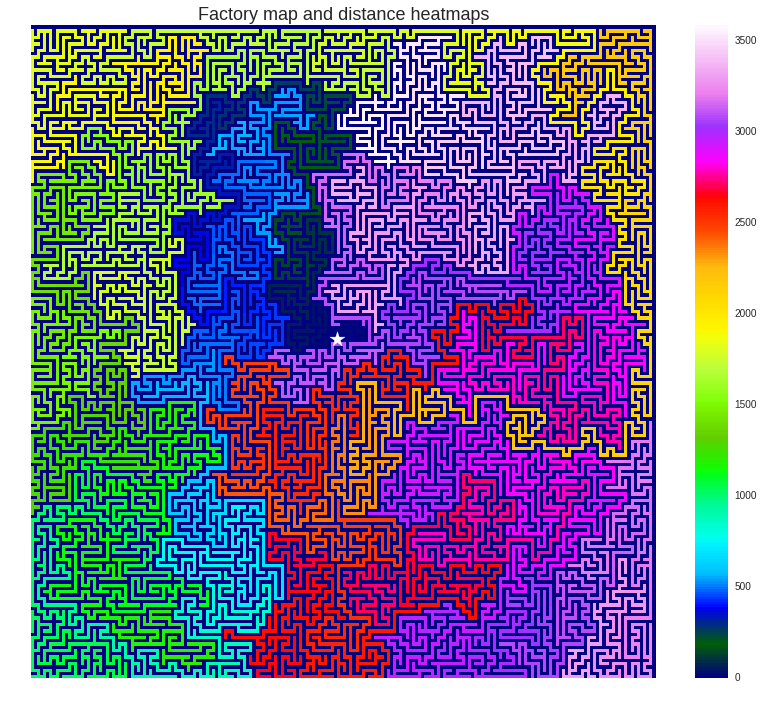


Maximum number of doors to reach: 3574
Number of rooms that needs at least >= 1000 doors to reach: 8444
CPU times: user 6.52 s, sys: 378 ms, total: 6.9 s
Wall time: 7.53 s


In [5]:
%%time
with open('day20.txt', 'r') as f:
  inputs = f.read()  
rooms = parse_path(inputs, verbose=True)